In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Scikit-Learn Models & Tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
def load_and_prep_data():
    train_path = '/content/drive/MyDrive/University/CSCI316 - Big Data Mining Techniques/Group Assignment/UNSW_NB15_training-set.csv'
    test_path = '/content/drive/MyDrive/University/CSCI316 - Big Data Mining Techniques/Group Assignment/UNSW_NB15_testing-set.csv'
    
    # Juwon's Local file path
    test_path = '/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/Group_Assignment_Database/UNSW_NB15_testing-set.csv'
    train_path = '/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/Group_Assignment_Database/UNSW_NB15_training-set.csv'
    
    # 1. Load both datasets
    print("Loading data...")
    df_train_orig = pd.read_csv(train_path)
    df_test_orig = pd.read_csv(test_path)

    # 2. Combine them
    df_full = pd.concat([df_train_orig, df_test_orig], axis=0).reset_index(drop=True)

    missing_data = df_full.isnull().sum()
    if missing_data.sum() > 0:
        print("\n[WARNING] Missing values detected:")
        print(missing_data[missing_data > 0])
    else:
        print("\n[CHECK] No true missing values (NaN) found.")

    # 3. Define Features and Target
    # We use 'label' for stratification to maintain class balance
    drop_cols = ['label', 'id', 'attack_cat']
    X = df_full.drop(drop_cols, axis=1)
    y = df_full['label']
    
    # 4. Stratified Split: Train (70%) and Temp (30%)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # 5. Split Temp into Validation (15%) and Test (15%)
    # 0.5 * 30% = 15%
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    # Now X_train, X_val, X_test/ y_train, y_val, y_test available
    
    # 6. Preprocessing (Label Encoding)
    le = LabelEncoder()
    categorical_cols = ['proto', 'service', 'state'] # attack_cat removed since already dropped
    for col in categorical_cols:
        # labelEncode each train/test/validation data
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_val[col] = le.fit_transform(X_val[col].astype(str))
        X_test[col] = le.fit_transform(X_test[col].astype(str))

    

    print(f"Features used for training ({len(X.columns)} total):")
    print(list(X.columns))
    print("-" * 50)

    print(f"Data Loaded and Split:")
    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

    return X_train, y_train, X_val, y_val, X_test, y_test

# Unpack the validation set
X_train, y_train, X_val, y_val, X_test, y_test = load_and_prep_data()

def check_distributions(y_train, y_val, y_test):
    sets = {'Train': y_train, 'Validation': y_val, 'Test': y_test}
    for name, set_data in sets.items():
        counts = set_data.value_counts(normalize=True) * 100
        print(f"{name} Distribution: Normal: {counts[0]:.2f}%, Attack: {counts[1]:.2f}%")

check_distributions(y_train, y_val, y_test)

Loading data...

[CHECK] No true missing values (NaN) found.
Features used for training (42 total):
['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']
--------------------------------------------------
Data Loaded and Split:
Train: (180371, 42), Val: (38651, 42), Test: (38651, 42)
Train Distribution: Normal: 36.09%, Attack: 63.91%
Validation Distribution: Normal: 36.09%, Attack: 63.91%
Test Distribution: Normal: 36.09%, Attack: 63.91%


In [3]:
class CustomFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, use_extra_features=True):
        self.use_extra_features = use_extra_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        if self.use_extra_features:
            if 'spkts' in X.columns and 'dpkts' in X.columns:
                X_transformed['pkt_ratio'] = (X_transformed['spkts'] + 1)/(X_transformed['dpkts'] + 1)
            if 'sttl' in X.columns and 'dttl' in X.columns:
              X_transformed['ttl_gap'] = abs(X_transformed['sttl'] - X_transformed['dttl'])
        return X_transformed


In [ ]:
def train_and_tune_rf(X_train, y_train, X_val, y_val):
    print("Starting Grid Search for Random Forest...")
    start_time = time.time()

    pipeline = Pipeline([
        ('custom_transformer', CustomFeatureTransformer()),
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
    ])

    param_grid = {
        'custom_transformer__use_extra_features': [True, False],
        'rf__n_estimators': [50, 100],
        'rf__max_depth': [None, 10, 20],
        'rf__criterion': ['gini', 'entropy']
    }

    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=3,
        scoring='f1',
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    results_df = pd.DataFrame(grid_search.cv_results_)

    # Extract and display all combination results
    results_df = pd.DataFrame(grid_search.cv_results_)
    relevant_results = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
    relevant_results = relevant_results.sort_values(by='rank_test_score')

    print("\n--- All Hyperparameter Combinations (Sorted by F1-Score) ---")
    print(relevant_results.to_string(index=False))

    # Validate the best model on the Validation set
    val_predictions = grid_search.best_estimator_.predict(X_val)
    val_f1 = f1_score(y_val, val_predictions)

    print(f"\nGrid Search Complete in {time.time() - start_time:.2f} seconds.")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Validation F1-Score: {val_f1:.4f}")

    return grid_search.best_estimator_

# Run the training
best_rf_model = train_and_tune_rf(X_train, y_train, X_val, y_val)



Starting Grid Search for Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


Preparing data for history tracking...
Recording metrics for up to 100 trees...


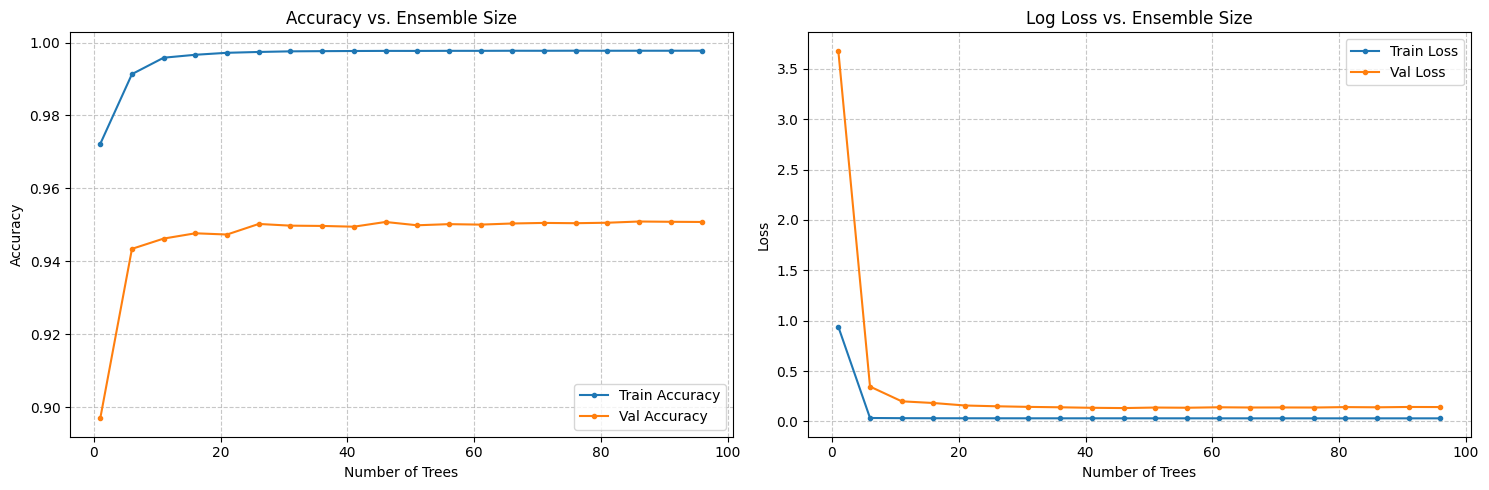

In [ ]:
def train_with_history(X_train, y_train, X_val, y_val, best_pipeline):
    print("Preparing data for history tracking...")

    # 1. Extract the best RF parameters and set warm_start
    rf_step = best_pipeline.named_steps['rf']
    rf_params = rf_step.get_params()
    rf_params['warm_start'] = True

    # 2. Extract the preprocessing steps (Transformer + Scaler)
    # This ensures your custom features are included in the chart metrics
    preprocessor = Pipeline(best_pipeline.steps[:-1])
    X_train_prepped = preprocessor.transform(X_train)
    X_val_prepped = preprocessor.transform(X_val)

    # 3. Initialize the RF with the best parameters (no duplicates)
    rf = RandomForestClassifier(**rf_params)

    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    # Define the range of trees to track (1 to the best n_estimators)
    max_trees = rf_params.get('n_estimators', 100)
    tree_range = range(1, max_trees + 1, 5)

    print(f"Recording metrics for up to {max_trees} trees...")

    for i in tree_range:
        rf.n_estimators = i
        rf.fit(X_train_prepped, y_train)

        # Calculate Log Loss (Cross-Entropy)
        train_loss.append(log_loss(y_train, rf.predict_proba(X_train_prepped)))
        val_loss.append(log_loss(y_val, rf.predict_proba(X_val_prepped)))

        # Calculate Accuracy
        train_acc.append(accuracy_score(y_train, rf.predict(X_train_prepped)))
        val_acc.append(accuracy_score(y_val, rf.predict(X_val_prepped)))

    # --- Visualization ---
    plt.figure(figsize=(15, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(tree_range, train_acc, label='Train Accuracy', marker='.', color='#1f77b4')
    plt.plot(tree_range, val_acc, label='Val Accuracy', marker='.', color='#ff7f0e')
    plt.title('Accuracy vs. Ensemble Size')
    plt.xlabel('Number of Trees')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot Loss (Log Loss)
    plt.subplot(1, 2, 2)
    plt.plot(tree_range, train_loss, label='Train Loss', marker='.', color='#1f77b4')
    plt.plot(tree_range, val_loss, label='Val Loss', marker='.', color='#ff7f0e')
    plt.title('Log Loss vs. Ensemble Size')
    plt.xlabel('Number of Trees')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Run this after your Grid Search
train_with_history(X_train, y_train, X_val, y_val, best_rf_model)


 FINAL PERFORMANCE ON TEST SET 

Classification Report:
              precision    recall  f1-score   support

      Normal     0.9281    0.9378    0.9329     13950
      Attack     0.9647    0.9589    0.9618     24701

    accuracy                         0.9513     38651
   macro avg     0.9464    0.9484    0.9474     38651
weighted avg     0.9515    0.9513    0.9514     38651



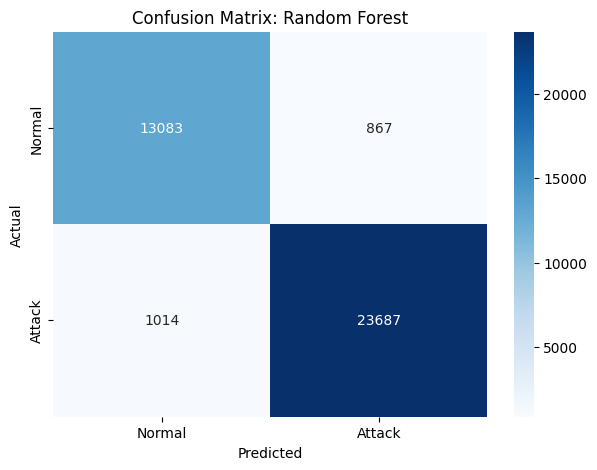

In [ ]:
def evaluate_model(model, X_test, y_test):
    print("\n" + "="*50)
    print(" FINAL PERFORMANCE ON TEST SET ")
    print("="*50)

    y_pred = model.predict(X_test)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack'], digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Attack'],
                yticklabels=['Normal', 'Attack'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix: Random Forest')
    plt.show()

# Execute final evaluation
evaluate_model(best_rf_model, X_test, y_test)